**Set seed**

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import torch

seed = 123
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed)

**Check we are actually working with GPU or not**

In [2]:
import tensorflow as tf
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

: /physical_device:CPU:0
: /physical_device:GPU:0


2023-01-09 18:47:31.688581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 18:47:31.947236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 18:47:31.948609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


**Load libraries**

In [6]:
from tensorflow.python.client import device_lib
import sys


from datetime import datetime


import pandas as pd


import re
import csv
import itertools

#import keras
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator



from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


#https://github.com/bnsreenu/python_for_microscopists/blob/master/213-ensemble_sign_language.py
#https://www.youtube.com/watch?v=-ix_Mjzu8BU
from sklearn.metrics import accuracy_score

**Read dataset**


In [7]:
train_directory = os.path.join('/kaggle/input/atl-censustract-hf/')


train_df = pd.read_csv('/kaggle/input/atl-censustract-hf-metadata/Data_analysis_wGoogle_360Paths.csv')
train_df.drop('Unnamed: 0', axis = 1, inplace = True)
train_df.drop('Unnamed: 0.1', axis = 1, inplace = True)
print(len(train_df))
train_df.head(5)

1501


,GEOID,POP10,INTPTLAT,INTPTLONG,readmitper,npatients,status,copyright,date,pano_id,location.lat,location.lng,file_name,image_path
0,13001950200,4530,31.809963,-82.316989,0.250000,4,OK,© Google,2008-01,Rr5fBl6nkE1lFFD8veNQqA,31.810433,-82.317197,13001950200_c.jpg,/Users/rodrigocarrillo/Box Sync/Computer Visio...
1,13001950300,5176,31.766806,-82.371963,0.200000,5,OK,© Google,2014-05,-PUWgFJalP4dxXOkfYzS6w,31.767304,-82.373161,13001950300_c.jpg,/Users/rodrigocarrillo/Box Sync/Computer Visio...
2,13001950500,3864,31.689265,-82.380962,0.000000,4,OK,© Google,2014-05,JnWpzuUoCd5rAoFAiu3xhQ,31.689086,-82.374153,13001950500_c.jpg,/Users/rodrigocarrillo/Box Sync/Computer Visio...
3,13003960300,1245,31.288721,-82.717356,0.000000,1,OK,© Google,2013-04,VNMliCL-kYXIQ_PwHDoYpQ,31.289599,-82.724457,13003960300_c.jpg,/Users/rodrigocarrillo/Box Sync/Computer Visio...
4,13009970200,6883,33.139980,-83.234698,0.285714,14,OK,© Google,2022-03,1K5d58Q3iHmtmk79lHD80A,33.140688,-83.231426,13009970200_c.jpg,/Users/rodrigocarrillo/Box Sync/Computer Visio...


**Re-generate the variable 'image' path to reflect the path here in Kaglle**

In [8]:
train_df['image_path'] = train_directory + train_df['file_name']

**There were some rows where popoulation was 0, drop these and check the distribution to make sure everything is >=1**

In [9]:
train_df = train_df[train_df['POP10'] > 0]
print(train_df['POP10'].describe())
print(len(train_df))

count     1500.000000
mean      5196.434667
std       2499.155414
min        914.000000
25%       3500.000000
50%       4836.500000
75%       6408.000000
max      20655.000000
Name: POP10, dtype: float64
1500


**Calculate the prevalence as number of patients / populaition and inspect the new variable**

count    1500.000000
mean        0.004193
std         0.006328
min         0.000101
25%         0.001012
50%         0.001814
75%         0.004036
max         0.045036
Name: prevalence, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

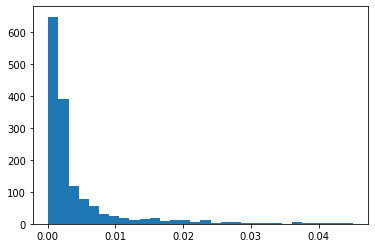

In [10]:
train_df['prevalence'] = train_df['npatients']/train_df['POP10']
print(train_df['prevalence'].describe())
plt.hist(train_df['prevalence'], bins = 30)
plt.show

In [11]:
print(train_df['image_path'].iloc[0])
print(' ') 
print(train_df['prevalence'].describe())

/kaggle/input/atl-censustract-hf/13001950200_c.jpg
 
count    1500.000000
mean        0.004193
std         0.006328
min         0.000101
25%         0.001012
50%         0.001814
75%         0.004036
max         0.045036
Name: prevalence, dtype: float64


**Check one image to verify the paths are working OK**

(640, 2560, 3)


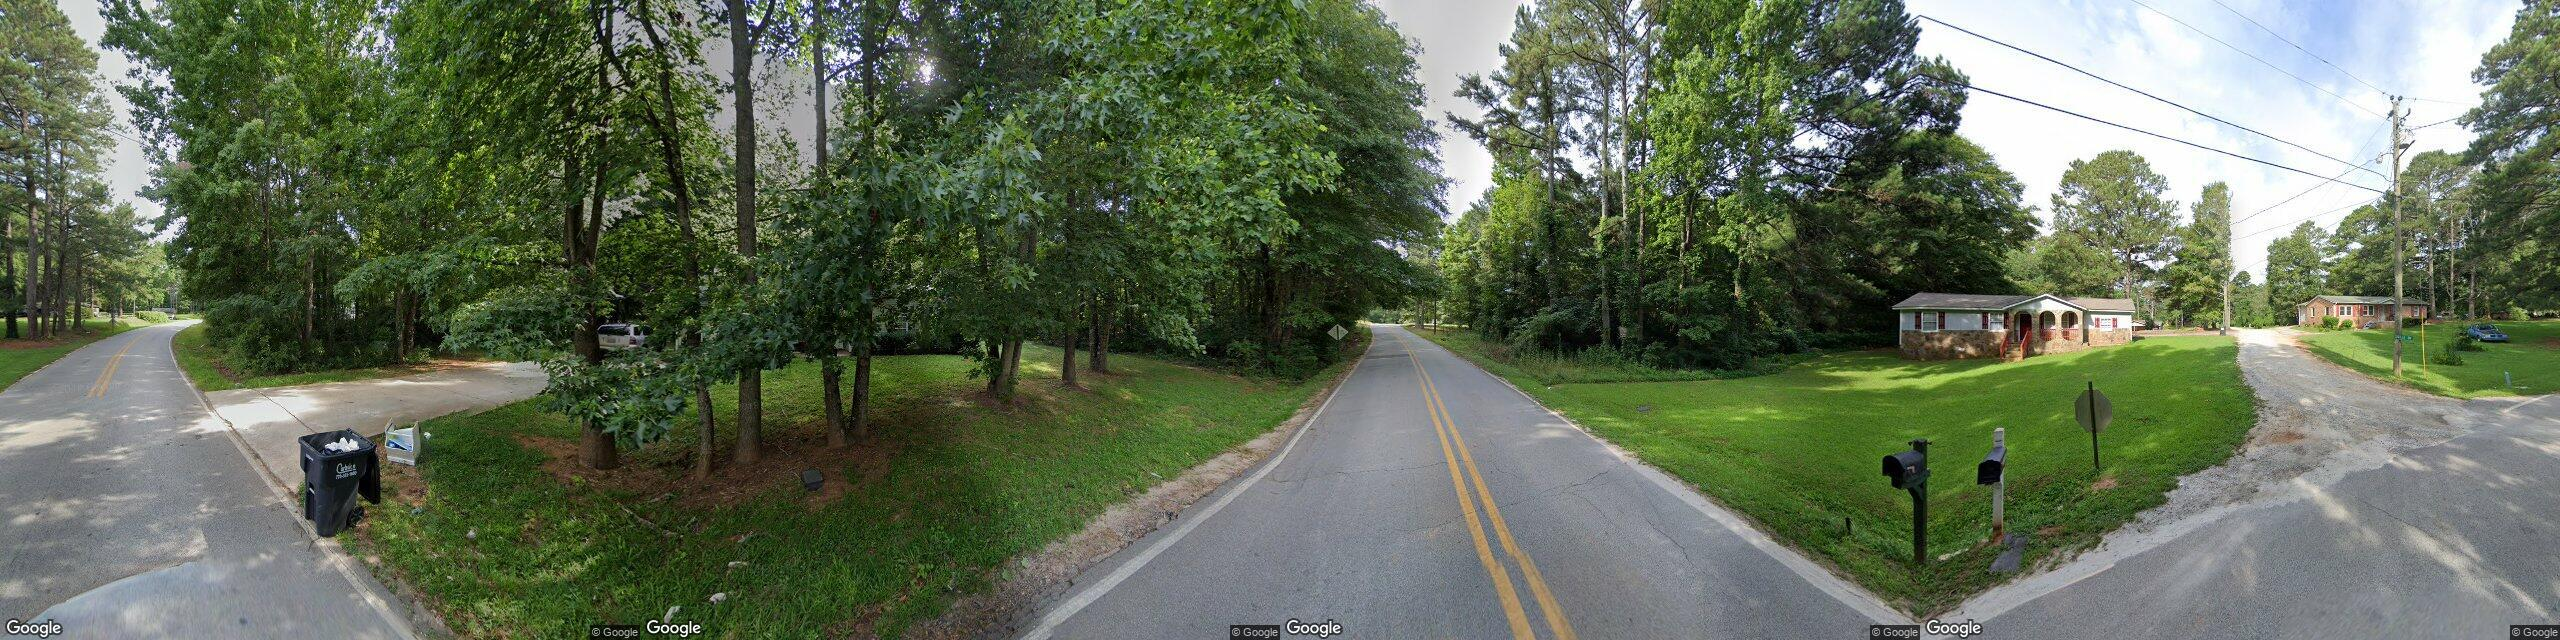

In [12]:
from IPython.display import Image
import cv2
print(cv2.imread(train_directory+os.listdir(train_directory)[10]).shape)
Image(filename = train_directory+os.listdir(train_directory)[10])

**The distribution of 'prevalence' was not normal at all, let's use box-cox to try to get it in a normal distribution**

 
 
count    1500.000000
mean       -5.986980
std         1.080627
min        -8.788090
25%        -6.663680
50%        -6.117338
75%        -5.363278
max        -3.052731
Name: prevalence, dtype: float64


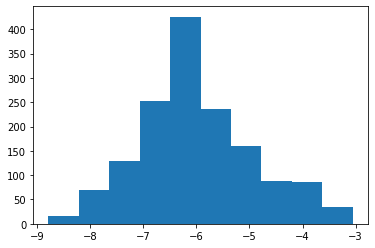

In [13]:
from scipy.special import boxcox, inv_boxcox


plt.hist(boxcox(train_df['prevalence'], 0.01))
train_df['prevalence'] = boxcox(train_df['prevalence'], 0.01)
print(' ')
print(' ')
print(train_df['prevalence'].describe())

**Create train, val and test dataframes**

In [14]:
df_x = train_df.drop('prevalence', axis = 1)
df_y = train_df['prevalence']


X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size = 0.40, random_state = 123)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = 123)

In [15]:
df_train = pd.concat([X_train, y_train], axis = 1)
df_test = pd.concat([X_test, y_test], axis = 1)
df_val = pd.concat([X_val, y_val], axis = 1)

In [16]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(900, 15)
(300, 15)
(300, 15)


In [ ]:
#print(df_train.head(2))
#print(df_val.head(2))
#print(df_test.head(2))

**ImageDataGenerator**

In [20]:
### ImageDataGenerator (we could try different options for data augmentation)
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen  = ImageDataGenerator(rescale = 1./255)

**Set the size of the image (which may change depending on the original architecture)**

In [21]:
image_height = 331
image_length = 331

**Create the three iterators for train, val and test**

In [22]:
### Iterator for Train dataset
train_iter = train_datagen.flow_from_dataframe(
    df_train,
    x_col = 'image_path',  # columna con el fichero
    y_col = 'prevalence',  # colummna con el target
    target_size = (image_height, image_length),
    class_mode = 'raw',
    #class_mode = 'other',
    #class_mode = 'categorical',
    #class_mode = 'binary',
    batch_size = 32,
    shuffle = True    # True por ser entrenamiento
)

Found 900 validated image filenames.


In [23]:
### Iterator for Validation dataset
valid_iter = valid_datagen.flow_from_dataframe(
    df_val,
    x_col = 'image_path',  # columna con el fichero
    y_col = 'prevalence',  # colummna con el target
    target_size = (image_height, image_length),
    class_mode = 'raw',
    #class_mode = 'other',
    #class_mode = 'categorical',
    #class_mode = 'binary',
    batch_size = 32,
    shuffle = False   # False por ser validation
)

Found 300 validated image filenames.


In [24]:
### Iterator for Test dataset
test_iter = test_datagen.flow_from_dataframe(
    df_test,
    x_col = 'image_path',  # columna con el fichero
    y_col = 'prevalence',  # colummna con el target
    target_size = (image_height, image_length),
    class_mode = 'raw',
    #class_mode = 'other',
    #class_mode = 'categorical',
    #class_mode = 'binary',
    batch_size = 32,
    shuffle = False   # False por ser test
)

Found 300 validated image filenames.


In [25]:
print(train_iter.image_shape)
print(valid_iter.image_shape)
print(test_iter.image_shape)

(331, 331, 3)
(331, 331, 3)
(331, 331, 3)


**Creat a model or load trained models (for transfer learning)**

In [22]:
#model = tf.keras.models.Sequential()
#model.add(tf.keras.layers.Conv2D(32, kernel_size = (5, 5), strides = (1, 1), activation = 'relu', input_shape = (image_height, image_length, 3)))
#model.add(tf.keras.layers.MaxPooling2D(strides = (2, 2), pool_size = (3, 3)))

#model.add(tf.keras.layers.Conv2D(16, kernel_size = (5, 5), strides = (1, 1), activation = 'relu'))
#model.add(tf.keras.layers.MaxPooling2D(strides = (2, 2), pool_size = (3, 3)))

#model.add(tf.keras.layers.Conv2D(4, kernel_size = (5, 5), strides = (1, 1), activation = 'relu'))
#model.add(tf.keras.layers.MaxPooling2D(strides = (2, 2), pool_size = (3, 3)))

#model.add(tf.keras.layers.Flatten())

#model.add(tf.keras.layers.Dense(8, activation = 'relu'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Dense(2, activation = 'relu'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Dense(1))


#model_2 = model

In [23]:
#model = vgg16.VGG16(
#                    input_shape = (image_length, image_height, 3),
#                    include_top = False,
#                    pooling = 'avg',
#                    weights = 'imagenet'
#                    )


#model.trainable = False


#x = Dense(4096, activation = 'relu', name = 'FC1-4096')(model.output)
#x = Dense(4096, activation = 'relu', name = 'FC2-4096')(x)
#x = Dense(1,
#          name = 'new_output')(model.output)


#model = Model(model.input, x)

In [24]:
model = nasnet.NASNetLarge(input_shape = (image_height, image_length, 3), 
                           include_top = False,
                           pooling = 'avg',
                           weights = 'imagenet')


model.trainable = False


x = Dense(1,
          name = 'new_output')(model.output)


model = Model(model.input, x)

2023-01-09 04:53:47.531169: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 04:53:47.531659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 04:53:47.532540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 04:53:47.533221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

343621632/343610240 [==============================] - 3s 0us/step


In [25]:
#model = resnet50.ResNet50(input_shape = (image_height, image_length, 3),
#                          include_top = False,
#                          pooling = 'avg',
#                          weights = 'imagenet')



#x = Dense(1,
#          name = 'new_output')(model.output)



#model = Model(model.input, x)

In [26]:
#model = ResNet152V2(input_shape = (image_height, image_length, 3),
#                          include_top = False,
#                          pooling = 'avg',
#                          weights = 'imagenet')



#x = Dense(1,
#          name = 'new_output')(model.output)



#model = Model(model.input, x)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
______________________________________________________________________________________________

**Model compile**

In [28]:
opt = Adam(learning_rate = 1e-3)
sgd = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(
                #optimizer = sgd,
                #optimizer = opt,
                #optimizer = 'adam',
                optimizer = 'Adadelta',
                #optimizer = 'Adamax',
                
                #metrics = METRICS,
                #metrics = ['accuracy'],
                metrics = ['mse'],
                
                #loss = 'binary_crossentropy'
                #loss = 'categorical_crossentropy'
                loss = 'mean_absolute_error'
                #loss = 'mse'
                #loss = 'mean_squared_logarithmic_error'
                )

**Check Points**

In [29]:
checkpointpath = "./Baseline.h5"
checkpoint = ModelCheckpoint(checkpointpath, 
                             #monitor = 'val_accuracy', 
                             monitor = 'val_loss',
                             verbose = 0, 
                             save_best_only = True,
                             #mode = 'max'
                             mode = 'min'
                             )
callbacks_list = [checkpoint]

**Reduce learning rate if not improving**

In [30]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.1,
                              patience = 1, 
                              min_lr = 0.0001,
                              cooldown = 1)

**Early stop if not improving**

In [31]:
early_stop = EarlyStopping(monitor = 'val_loss', 
                           patience = 5,
                           mode = 'min')

**Fit the model**

In [33]:
number_epoch = 500


modelfitprogress2 = model.fit(
                              train_iter,
                              steps_per_epoch = df_train.shape[0]//train_iter.batch_size,
                              validation_data = valid_iter,
                              epochs = number_epoch,
                              validation_steps = df_val.shape[0]//valid_iter.batch_size,
                              callbacks = [reduce_lr, early_stop, checkpoint]
                              )

2023-01-09 04:55:07.966301: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2023-01-09 04:55:20.112609: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


28/28 [==============================] - 75s 2s/step - loss: 1.0504 - mse: 1.7628 - val_loss: 1.0553 - val_mse: 1.7270


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/500
28/28 [==============================] - 43s 2s/step - loss: 1.0460 - mse: 1.7596 - val_loss: 1.0553 - val_mse: 1.7270
Epoch 3/500
28/28 [==============================] - 43s 2s/step - loss: 1.0446 - mse: 1.7578 - val_loss: 1.0553 - val_mse: 1.7269
Epoch 4/500
28/28 [==============================] - 43s 2s/step - loss: 1.0514 - mse: 1.7775 - val_loss: 1.0553 - val_mse: 1.7269
Epoch 5/500
28/28 [==============================] - 42s 2s/step - loss: 1.0448 - mse: 1.7603 - val_loss: 1.0553 - val_mse: 1.7269
Epoch 6/500
28/28 [==============================] - 43s 2s/step - loss: 1.0519 - mse: 1.7773 - val_loss: 1.0553 - val_mse: 1.7268
Epoch 7/500
28/28 [==============================] - 42s 2s/step - loss: 1.0494 - mse: 1.7707 - val_loss: 1.0553 - val_mse: 1.7268
Epoch 8/500
28/28 [==============================] - 42s 2s/step - loss: 1.0451 - mse: 1.7534 - val_loss: 1.0552 - val_mse: 1.7268
Epoch 9/500
28/28 [==============================] - 42s 2s/step - loss: 1.0427 - m

**Check the trainig progression in the train and validation sets**

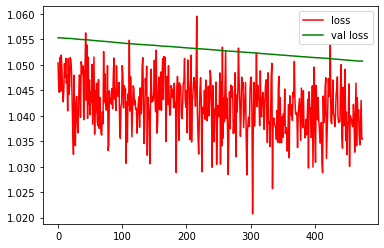

In [34]:
plt.plot(modelfitprogress2.history['loss'], color = 'red', label = 'loss')
plt.plot(modelfitprogress2.history['val_loss'], color = 'green', label = 'val loss')
plt.legend(loc = 'upper right')
plt.show()

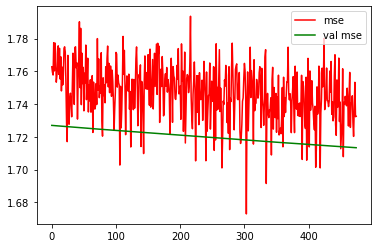

In [35]:
plt.plot(modelfitprogress2.history['mse'], color = 'red', label = 'mse')
plt.plot(modelfitprogress2.history['val_mse'], color = 'green', label = 'val mse')
plt.legend(loc = 'upper right')
plt.show()

**Load the best model saved**

In [26]:
model = load_model('/kaggle/input/model-test/Baseline (11).h5')

**Estimate loss and metric in val and test sets**

In [27]:
score = model.evaluate(valid_iter, steps = df_val.shape[0]//valid_iter.batch_size)
print("Loss in validation: {} \nMSE in validation: {}".format(score[0], score[1]))

2023-01-09 18:49:48.793466: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-09 18:49:56.029124: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


9/9 [==============================] - 25s 1s/step - loss: 1.0507 - mse: 1.7135
Loss in validation: 1.050722599029541 
MSE in validation: 1.7134840488433838


In [28]:
score = model.evaluate(test_iter, steps = df_test.shape[0]//test_iter.batch_size)
print("Loss in test: {} \nMSE in test: {}".format(score[0], score[1]))

9/9 [==============================] - 13s 1s/step - loss: 1.0651 - mse: 1.8746
Loss in test: 1.0651496648788452 
MSE in test: 1.874619960784912


**Make predictions**

In [29]:
prediction = model.predict(test_iter, steps = np.math.ceil(test_iter.samples/test_iter.batch_size))
print(prediction)

[[-4.484282 ]
 [-6.6127357]
 [-4.998436 ]
 [-7.171892 ]
 [-6.567854 ]
 [-6.9309945]
 [-3.8148732]
 [-6.5548077]
 [-5.0463905]
 [-3.9560664]
 [-5.949134 ]
 [-6.3927617]
 [-4.9685235]
 [-5.9632154]
 [-6.8640127]
 [-5.7063303]
 [-5.078989 ]
 [-7.096939 ]
 [-6.368176 ]
 [-6.2737865]
 [-5.415806 ]
 [-4.9840384]
 [-5.9573674]
 [-4.7827725]
 [-4.8176384]
 [-5.7253356]
 [-6.0434165]
 [-6.0275025]
 [-6.4567766]
 [-6.605927 ]
 [-5.4189997]
 [-5.818033 ]
 [-6.239492 ]
 [-4.6879625]
 [-5.809097 ]
 [-6.0771947]
 [-5.7202663]
 [-5.491709 ]
 [-7.240348 ]
 [-6.2231865]
 [-6.9818892]
 [-5.2369466]
 [-6.905772 ]
 [-6.118643 ]
 [-6.598181 ]
 [-5.527761 ]
 [-5.912592 ]
 [-5.0692077]
 [-5.477595 ]
 [-6.356093 ]
 [-5.6178074]
 [-7.553704 ]
 [-5.566833 ]
 [-4.563916 ]
 [-5.9390206]
 [-6.4272256]
 [-5.6783442]
 [-6.198083 ]
 [-6.856305 ]
 [-6.903036 ]
 [-6.188657 ]
 [-6.5971546]
 [-4.8294344]
 [-7.2044864]
 [-4.921579 ]
 [-4.782994 ]
 [-5.1916184]
 [-5.407525 ]
 [-5.3128104]
 [-5.96878  ]
 [-5.167191 ]
 [-6.7

**Check again the metrics in the test dataset versus the predictions**

In [30]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print('Model HOMA-B - R2: %.3f' % r2_score(y_test, prediction))
print('Model HOMA-B - Mean Squared Error: %.3f' % mean_squared_error(y_test, prediction))
print('Model HOMA-B - Mean Absolute Error: %.3f' % mean_absolute_error(y_test, prediction))

Model HOMA-B - R2: -0.557
Model HOMA-B - Mean Squared Error: 1.946
Model HOMA-B - Mean Absolute Error: 1.082


**Scatter predicted verus observed in the test dataset**

Text(0.5, 0, 'Observed')

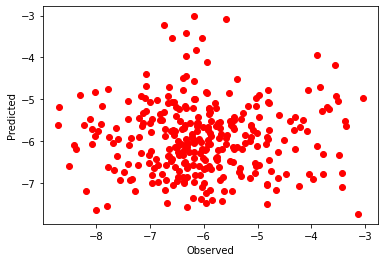

In [31]:
plt.plot(y_test, prediction, 'ro')
plt.ylabel('Predicted')
plt.xlabel('Observed')
#plt.xlim(-2, 10)
#plt.ylim(-2, 10)
#plt.axline([0, 0], [1, 1])

**In the test dataset create a new column with the predictions and look at it.**


**MANUEL** - Mira esta tabla (la de head). La primera fila dice que la prevalencia es -6.384242 y el predicho es -4.484282.

In [32]:
df_test = pd.concat([df_test.reset_index(drop = True), 
                     pd.DataFrame(prediction, columns = ['predicted'])], 
                     axis = 1)
print(df_test.shape)
df_test[['image_path', 'prevalence', 'predicted']].head(10)

(300, 16)


,image_path,prevalence,predicted
0,/kaggle/input/atl-censustract-hf/13057091001_c...,-6.384242,-4.484282
1,/kaggle/input/atl-censustract-hf/13129970900_c...,-6.540341,-6.612736
2,/kaggle/input/atl-censustract-hf/13019970600_c...,-6.170191,-4.998436
3,/kaggle/input/atl-censustract-hf/13247060404_c...,-4.655134,-7.171892
4,/kaggle/input/atl-censustract-hf/13063040512_c...,-4.970509,-6.567854
5,/kaggle/input/atl-censustract-hf/13185010500_c...,-7.364424,-6.930995
6,/kaggle/input/atl-censustract-hf/13059130500_c...,-6.145855,-3.814873
7,/kaggle/input/atl-censustract-hf/13051001100_c...,-7.404135,-6.554808
8,/kaggle/input/atl-censustract-hf/13121007807_c...,-3.504102,-5.046391
9,/kaggle/input/atl-censustract-hf/13313000502_c...,-6.335740,-3.956066


**Check again the results using the new test dataset (containing the predictions as a new column). These results should be identical to those before.**

In [33]:
print('R2: %.3f' % r2_score(df_test[['prevalence']], df_test[['predicted']]))
print('Mean Squared Error: %.3f' % mean_squared_error(df_test[['prevalence']], df_test[['predicted']]))
print('Mean Absolute Error: %.3f' % mean_absolute_error(df_test[['prevalence']], df_test[['predicted']]))

R2: -0.557
Mean Squared Error: 1.946
Mean Absolute Error: 1.082


**Remember that originally we transformed the outcome using box-cox, let's transform back to the original units. Back-transform the observed and predicted.**

In [34]:

df_test['prevalence'] = inv_boxcox(df_test['prevalence'], 0.01)
df_test['predicted']  = inv_boxcox(df_test['predicted'], 0.01)
print(df_test[['prevalence', 'predicted']].head(10))
print(' ')
print(' ')
print(df_test[['prevalence', 'predicted']].describe())
print(' ')
print(' ')


   prevalence  predicted
0    0.001364   0.010174
1    0.001155   0.001068
2    0.001714   0.005930
3    0.008506   0.000586
4    0.006107   0.001121
5    0.000476   0.000759
6    0.001759   0.020455
7    0.000456   0.001137
8    0.028241   0.005638
9    0.001437   0.017660
 
 
       prevalence   predicted
count  300.000000  300.000000
mean     0.004218    0.003560
std      0.006769    0.005456
min      0.000111    0.000315
25%      0.001011    0.001109
50%      0.001798    0.002150
75%      0.003755    0.003702
max      0.045036    0.046769
 
 


**Estimate the results now using the variables (observed and predicted) in the correct units.**

In [35]:
print('R2: %.3f' % r2_score(df_test[['prevalence']], df_test[['predicted']]))
print('Mean Squared Error: %.3f' % mean_squared_error(df_test[['prevalence']], df_test[['predicted']]))
print('Mean Absolute Error: %.3f' % mean_absolute_error(df_test[['prevalence']], df_test[['predicted']]))

R2: -0.644
Mean Squared Error: 0.000
Mean Absolute Error: 0.004


**Plot the results with the correct units.**

(0.0, 0.05)

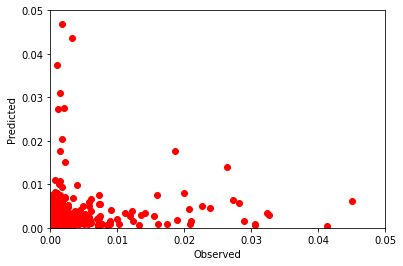

In [36]:
plt.plot(df_test[['prevalence']], df_test[['predicted']], 'ro')
plt.ylabel('Predicted')
plt.xlabel('Observed')
plt.xlim(0, 0.05)
plt.ylim(0, 0.05)
#plt.axline([0, 0], [1, 1])

**Save the test dataset**

In [46]:
df_test.to_csv('./Baseline.csv')

**Let's try to predict one image at the time to double check the results.**

**Check one image.**

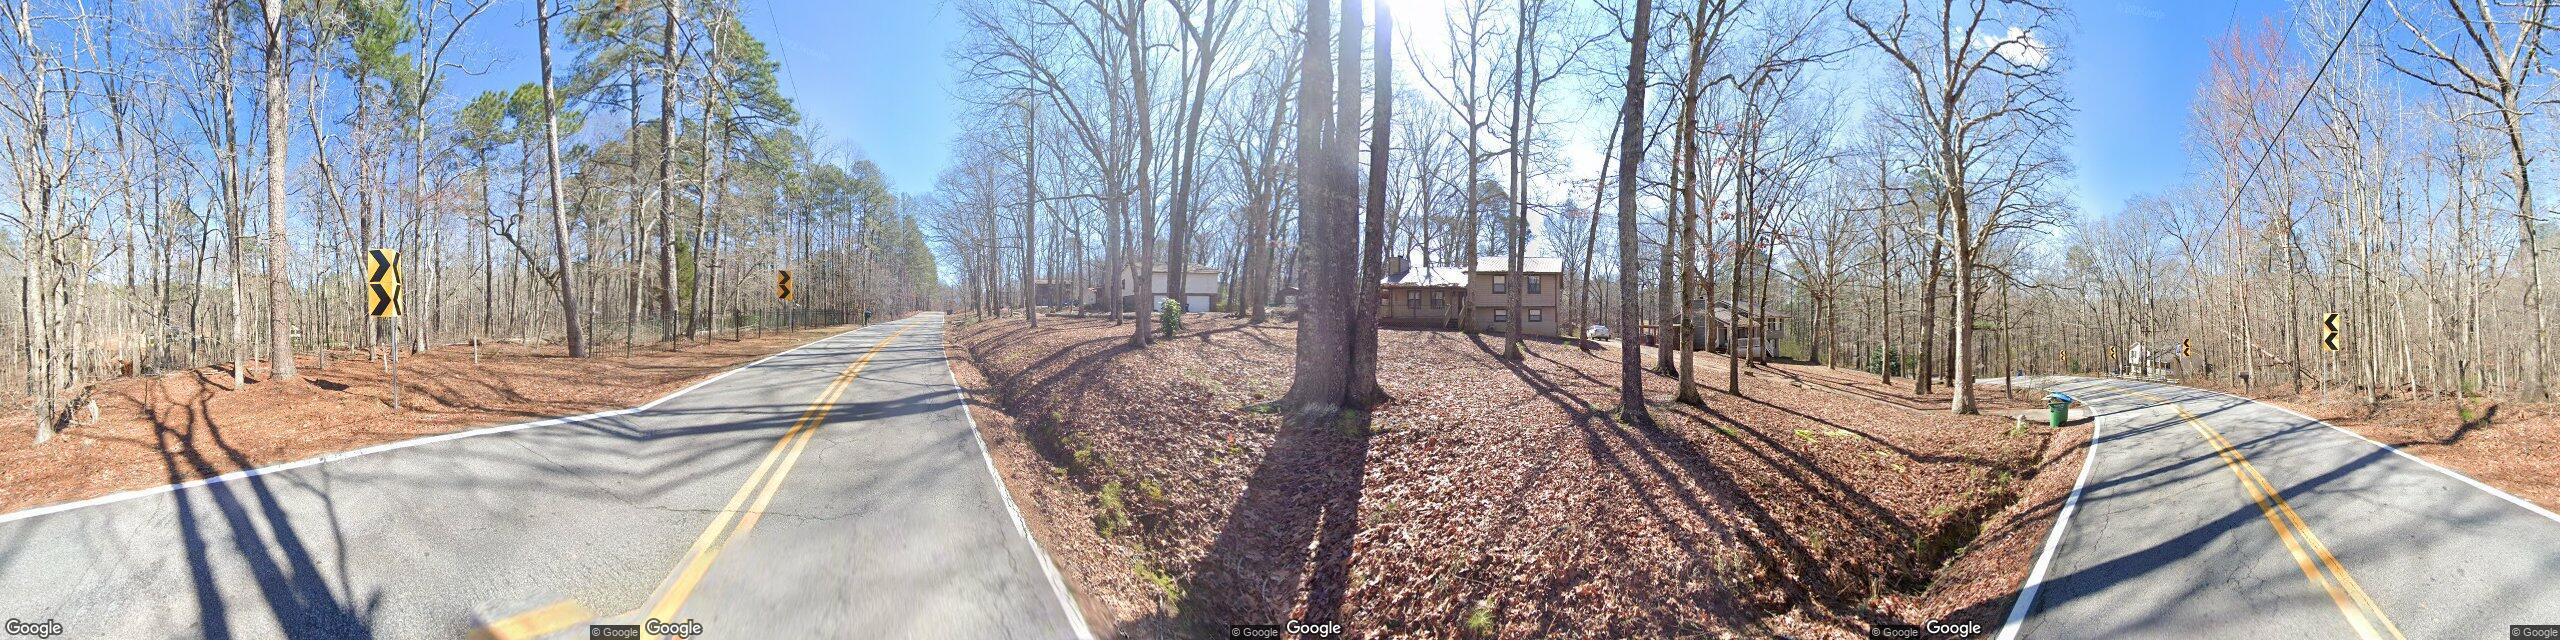

In [37]:
Image(filename = df_test['image_path'].iloc[0])

**We need to read one image, resize and reshape (remember we need a tensor of 4 dimensions). Then pass the image to the model and predict.**



**MANUEL** - Aqui se supone que estamos usando la misma imagen que en mi mensaje anterior. Sin embargo, la prediccion dice -4.340803 cuando arriba (en mi  mensaje anterior) dice -4.484282. No son tan distintos, pero no son iguales. En otros casos la diferencia es un poco mas.


In [38]:

def load(filename):
   np_image = cv2.imread(filename)
   np_image = np_image/255
   np_image = cv2.resize(np_image, (331, 331))
   np_image = np_image.reshape(1, 331, 331, 3)
   return np_image

image = load(df_test['image_path'].iloc[0])
predicted = model.predict(image)
predicted

array([[-4.340803]], dtype=float32)

In [39]:
inv_boxcox(predicted[0][0], 0.01)

0.011821511940454004

In [40]:
df_test['prevalence'].iloc[0]

0.0013642564802182813

**Now let's predict for ALL the images. Create a dummy column where we will save the predictions. Use a loop to pass each image path to the model and save the predictions.**

In [41]:

df = pd.concat([df_train, df_val, df_test], ignore_index = True)



df['predicted'] = np.NaN
for i in range(df.shape[0]):
    image = load(df['image_path'].iloc[i])
    predicted = model.predict(image)
    df['predicted'].iloc[i] = inv_boxcox(predicted[0][0], 0.01)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


**Check the predictions.**

In [42]:
df['predicted']

0       0.005415
1       0.002364
2       0.001136
3       0.000607
4       0.012719
          ...   
1495    0.001954
1496    0.002180
1497    0.004235
1498    0.000488
1499    0.003031
Name: predicted, Length: 1500, dtype: float64

**Check the results in the new dataset containing ALL images and predictions.**

In [43]:
print('R2: %.3f' % r2_score(df[['prevalence']], df[['predicted']]))
print('Mean Squared Error: %.3f' % mean_squared_error(df[['prevalence']], df[['predicted']]))
print('Mean Absolute Error: %.3f' % mean_absolute_error(df[['prevalence']], df[['predicted']]))

R2: -3.447
Mean Squared Error: 29.534
Mean Absolute Error: 4.786


**Plot the predictions vs the observed data.**

(0.0, 0.05)

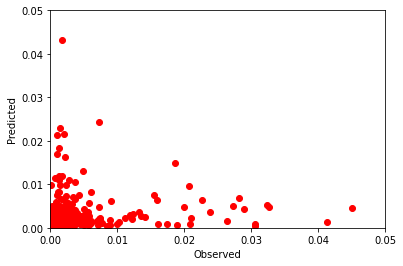

In [44]:
plt.plot(df[['prevalence']], df[['predicted']], 'ro')
plt.ylabel('Predicted')
plt.xlabel('Observed')
plt.xlim(0, 0.05)
plt.ylim(0, 0.05)
#plt.axline([0, 0], [1, 1])